<a href="https://colab.research.google.com/github/bhawana19/Minor-Project-2020-21/blob/main/Minor-Project-2020-21/Bhawana/Matching_audio_with_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os, sys
import shutil
import glob
import json
import collections
import tensorflow as tf
import numpy as np
import librosa
import random
from scipy.stats import entropy

import keras
from keras.models import Model, load_model
import keras.backend as K
from keras.applications.mobilenet import MobileNet
from keras.preprocessing import image
from IPython.display import Audio, Image, display_jpeg, display

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def preprocess_image(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [ ]:
def get_image_features(model, filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_image(x)
    preds = model.predict(x)[0]
    return preds

In [ ]:
def get_sound_features(model,filepath):
    x, sr = librosa.load(filepath)
    x = x * 255.0
    x = np.reshape(x, (1, x.shape[0], 1, 1))
    x[x < -255.] = -255.
    x[x > 255.] = 255.
    assert np.max(x) < 256., "It seems this audio contains signal that exceeds 256"
    assert np.min(x) > -256., "It seems this audio contains signal that exceeds -256 " + str(np.min(x)) + " : " + filepath
    _y_pred = model.predict(x)
    feature =  _y_pred[0][0][0][0]
    return feature

In [ ]:
def get_topk_songs(img_feature, song_features, k=3):
    distances = []
    for i in range(len(song_features)):
        distance = entropy(img_feature, song_features[i])
        distances.append(distance)
    topk_indecies = np.argsort(distances)[:k]
    return topk_indecies

In [ ]:
def create_sound_libs(
    soundnet_model,
    query="/content/drive/MyDrive/data/data/sound_samples/*.mp3",
    out_json_path="/content/drive/MyDrive/data/data/sounds.json",
    out_npy_path='/content/drive/MyDrive/data/data/song_features.npy'
):
    mp3_files = glob.glob(query)
    output_dict = {"mp3":[]}
    for i in range(len(mp3_files)):
        x, sr = librosa.load(mp3_files[i])
        if len(x) > 230000:
            output_dict["mp3"].append({"filepath":mp3_files[i], "index":str(i)})
    with open(out_json_path, "w")  as f:
        json.dump(output_dict, f, ensure_ascii=False, indent=4, sort_keys=True, separators=(',', ': '))
    song_features = []
    for item in output_dict["mp3"]:
        i_feature = get_sound_features(soundnet_model,item['filepath'])
        song_features.append(i_feature)
    song_features = np.array(song_features)
    print("Sound npy shape:", song_features.shape)
    np.save(out_npy_path, song_features)
    return (output_dict, song_features)

In [ ]:
soundnet = load_model("/content/drive/MyDrive/data/data/models/soundnet.hdf5")
imagenet = MobileNet(include_top=True, weights='imagenet') # using MobileNet

17235968/17225924 [==============================] - 2s 0us/step


In [ ]:
# create sound features using SoundNet model
(mp3_files, sound_features) = create_sound_libs(soundnet)

print
print "#of mp3 files", len(mp3_files['mp3'])

('Sound npy shape:', (268, 1000))

#of mp3 files 268


In [ ]:
# or, load pre-processed json data
with open("/content/drive/MyDrive/data/data/sounds.json") as f:
    mp3_files = json.load(f)
sound_features = np.load("/content/drive/MyDrive/data/data/song_features.npy")

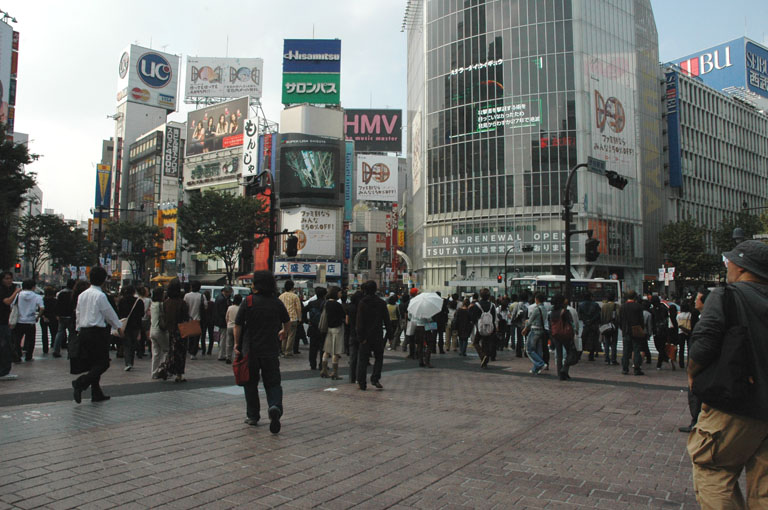

In [ ]:
IMG_PATH = "/content/drive/MyDrive/data/data/image_samples/town.jpg"
display_jpeg(Image(IMG_PATH))

In [ ]:
# Extract image features using ImageNet model(MobileNet)
img_feature = get_image_features(imagenet, IMG_PATH)

# Match the image features and pre-processed sound features,
# then find the topK best matched sound files 
topk_indecies = get_topk_songs(img_feature, sound_features, k=3)

In [ ]:
print("The best-matched sound:")
print

for i in range(3):
    print "Top #", i
    display(Audio(mp3_files["mp3"][topk_indecies[i]]["filepath"]))

The best-matched sound:

Top # 0


Top # 1


Top # 2
